In [4]:
import numpy as np
import os
import skimage as sk
import skimage.io as skio
from skimage.util import img_as_ubyte
from helper import *
import cv2

In [5]:
def zncc(image1, image2, eps: float = 1e-12):
    """Compute the normalized cross-correlation between two images."""
    # Normalize each vector
    image1_flat = image1.ravel()
    image2_flat = image2.ravel()
    norm1 = (image1_flat - image1_flat.mean())
    norm2 = (image2_flat - image2_flat.mean())
    denoms = np.linalg.norm(norm1) * np.linalg.norm(norm2) + eps

    return np.dot(norm1, norm2) / denoms

def ncc(image1, image2, eps: float = 1e-12):
    """Compute the normalized cross-correlation between two images."""
    # Normalize each vector
    image1_flat = image1.ravel()
    image2_flat = image2.ravel()
    norm1 = image1_flat
    norm2 = image2_flat
    denoms = np.linalg.norm(norm1) * np.linalg.norm(norm2)

    return np.dot(norm1, norm2) / denoms

def l2_norm(image1, image2):
    """Compute the L2 norm between two images."""
    return -np.linalg.norm(image1 - image2)

In [6]:
def crop_side(img, percent=0.01, fixed=20):
    h, w = img.shape
    crop_h = max(int(h * percent), fixed)
    crop_w = max(int(w * percent), fixed)
    img = img[crop_h:img.shape[0]-crop_h, crop_w:img.shape[1]-crop_w]
    return img

In [7]:
def overlap_views_func(img1, img2, dy, dx):
    """Return two cropped views (no wrap) that overlap when img2 is shifted by (dy, dx)."""
    H, W = img1.shape
    y0 = max(0,  dy); y1 = min(H, H + dy)
    x0 = max(0,  dx); x1 = min(W, W + dx)
    # Corresponding regions in img1 and shifted img2
    v1 = img1[y0:y1, x0:x1]
    v2 = img2[y0-dy:y1-dy, x0-dx:x1-dx]
    return v1, v2

def cal_metric(metric_func, img1, img2, dy, dx):
    im1, im2 = overlap_views_func(img1, img2, dy, dx)
    return metric_func(im1, im2)

In [8]:
def convolve(img, kernel, pad=False, mode='constant'):
    kh, kw = kernel.shape
    # do zero padding to preserve image shape
    if pad:
        pad_width = ((kh - 1) // 2, (kw - 1) // 2)
        img = np.pad(img, pad_width=(pad_width, pad_width), mode=mode)

    patches = np.lib.stride_tricks.sliding_window_view(img, (kh, kw))
    return np.einsum('ijkl,kl->ij', patches, kernel)

In [9]:
def gaussianFilter(img, mode='reflect', pad=False):
    return convolve(img, gaussianKernelBig, pad=pad, mode=mode)

In [23]:
def align_index(window, img1, img2, metric_func=l2_norm, overlap_views=True):
    win_h, win_w = window[0], window[1]
    max_metric= float('-inf')
    best_h, best_w = 0, 0
    for h in range(-win_h, win_h):
        for w in range(-win_w, win_w):
            img2_shift = np.roll(img2, shift=(h, w), axis=(0, 1))
            # compute the distance between the two images
            if overlap_views:
                metric = cal_metric(metric_func, img1, img2_shift, dy=h, dx=w)
            else:
                metric = metric_func(img1, img2_shift)
            if metric > max_metric:
                max_metric = metric
                best_h = h
                best_w = w
    return best_h, best_w

def align(window, img1, img2, level=3, metric_func=l2_norm, overlap_views=True, default_window=(5,5), percent=0.06):
    img1_for_align = crop_side(img1, percent=percent, fixed=65)
    img2_for_align = crop_side(img2, percent=percent, fixed=65)

    best_h, best_w = image_pyramid_align(window, img1_for_align, img2_for_align, level, 
                                         metric_func=metric_func, overlap_views=overlap_views, default_window=default_window)
    print(f"Best shift: ({best_h}, {best_w})")
    align_img = np.roll(img2, shift=(best_h, best_w), axis=(0, 1))
    return align_img, (best_h, best_w)

In [ ]:

def image_pyramid_align(window, img1, img2, levels, metric_func=l2_norm, overlap_views=True, default_window=(5,5)):
    """Align img2 to img1 using image pyramid approach."""
    # img1 = img1[0:img1.shape[0]-2, :]
    # img2 = img2[0:img2.shape[0]-2, :]
    # img1 = crop_side(img1, percent=0.01, fixed=90)
    # img2= crop_side(img2, percent=0.01, fixed=90)
    # corase level search
    if levels == 1:
        # print(f'window {window}')
        # skio.imshow(img1)
        # skio.show()
        curr_best_index_h, curr_best_index_w = align_index(window, img1, img2, metric_func, overlap_views)
        print(f"{curr_best_index_h} , {curr_best_index_w}")
        return curr_best_index_h, curr_best_index_w
    elif img1.shape[0] <= 100 or img1.shape[1] <= 100:
        # skio.imshow(img1)
        # skio.show()
        curr_best_index_h, curr_best_index_w = align_index(window, img1, img2, metric_func, overlap_views)
        # print(f"{curr_best_index_h} , {curr_best_index_w}")
        return curr_best_index_h, curr_best_index_w
    else:
        filter_img1 = gaussianFilter(img1, pad=True, mode='reflect')
        filter_img1 = filter_img1[::2, ::2] # downsample
        filter_img2 = gaussianFilter(img2, pad=True, mode='reflect')
        filter_img2 = filter_img2[::2, ::2] # downsample

        prev_best_index_h, prev_best_index_w = image_pyramid_align(window, filter_img1, filter_img2, levels-1, 
                                                                   metric_func=metric_func, overlap_views=overlap_views)
        
        aligned_img2 = np.roll(img2, shift=(prev_best_index_h*2, prev_best_index_w*2), axis=(0, 1))

        curr_best_index_h, curr_best_index_w = align_index(default_window, img1, aligned_img2, 
                                                           metric_func=metric_func, 
                                                           overlap_views=overlap_views)
        
        # print(f"{prev_best_index_h*2 + curr_best_index_h} , {prev_best_index_w*2 + curr_best_index_w}")
        return prev_best_index_h*2 + curr_best_index_h, prev_best_index_w*2 + curr_best_index_w

In [50]:
# fast version
def image_pyramid_align_fast(window, img1, img2, levels, metric_func=l2_norm, overlap_views=True, default_window=(5,5)):
    """Align img2 to img1 using image pyramid approach."""
    default_window = (5,5)
    # corase level search
    if levels == 1:
        # print(img1.shape)
        #print(f'window {window}')
        curr_best_index_h, curr_best_index_w = align_index(window, img1, img2, metric_func)
        # print(f"{curr_best_index_h} , {curr_best_index_w}")
        return curr_best_index_h, curr_best_index_w
    else:
        filter_img1 = cv2.resize(img1, dsize=None, fx=0.25, fy=0.25)
        filter_img2 = cv2.resize(img2, dsize=None, fx=0.25, fy=0.25)

        prev_best_index_h, prev_best_index_w = image_pyramid_align_fast(window, 
                                                                        filter_img1, 
                                                                        filter_img2,
                                                                        levels-1, 
                                                                        metric_func=metric_func,
                                                                        overlap_views=True
                                                                        , default_window=(5,5))
        aligned_img2 = np.roll(img2, shift=(prev_best_index_h*2, prev_best_index_w*2), axis=(0, 1))

        curr_best_index_h, curr_best_index_w = align_index(default_window, img1, aligned_img2, 
                                                           metric_func=metric_func, 
                                                           overlap_views=overlap_views)
        
        # print(f"{prev_best_index_h*2 + curr_best_index_h} , {prev_best_index_w*2 + curr_best_index_w}")
        return prev_best_index_h*4 + curr_best_index_h, prev_best_index_w*4 + curr_best_index_w


In [24]:
def align_img(img_path):
    # name of the input file
    imname = img_path

    # read in the image
    im = skio.imread(imname)

    # convert to double (might want to do this later on to save memory)    
    im = sk.img_as_float(im)
        
    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(int)

    # separate color channels
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]

    ag, ag_shift = align((20, 20), b, g, 6, metric_func=ncc, overlap_views=True, default_window=(5,5))
    ar, ar_shift = align((20, 20), b, r, 6, metric_func=ncc, overlap_views=True, default_window=(5,5))
    im_out = np.dstack([ar, ag, b])

    filename, ext = os.path.splitext(os.path.basename(imname))
    fname = f'./output/{filename}_align.jpg'
    skio.imsave(fname, img_as_ubyte(im_out))

    with open("img_shift_data.txt", "a") as f:
        f.write(f"{filename} best shift (y,x) is ag: {ag_shift}, ar: {ar_shift} \n")

    # display the image
    skio.imshow(im_out)
    skio.show()

Best shift: (47, 24)
Best shift: (0, -699)


/var/folders/g4/d17nd2p53bs410zfk4zdgzr40000gn/T/ipykernel_1026/1606876356.py:31: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(im_out)
/var/folders/g4/d17nd2p53bs410zfk4zdgzr40000gn/T/ipykernel_1026/1606876356.py:32: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


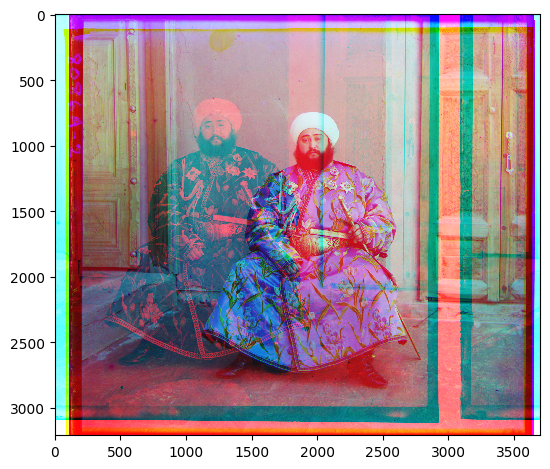

In [25]:
img_list = [
    # 'proj1_data/cathedral.jpg',
    # 'proj1_data/monastery.jpg',
    # 'proj1_data/tobolsk.jpg',
    # 'proj1_data/addon_img/master-pnp-prok-00100-00185a.tif',
    # 'proj1_data/addon_img/master-pnp-prok-00200-00251a.tif',
    # 'proj1_data/church.tif',
    # 'proj1_data/harvesters.tif',
    # 'proj1_data/icon.tif',
    # 'proj1_data/italil.tif',
    'proj1_data/emir.tif',
    # 'proj1_data/lastochikino.tif',
    # 'proj1_data/lugano.tif',
    # 'proj1_data/melons.tif',
    # 'proj1_data/self_portrait.tif',
    # 'proj1_data/siren.tif',
    # 'proj1_data/three_generations.tif'
]
for img in img_list:
    align_img(img)

In [27]:
def image_pyramid_align(window, img1, img2, levels, metric_func=l2_norm, overlap_views=True, default_window=(5,5)):
    """Align img2 to img1 using image pyramid approach."""
    # img1 = img1[0:img1.shape[0]-2, :]
    # img2 = img2[0:img2.shape[0]-2, :]
    # img1 = crop_side(img1, percent=0.01, fixed=90)
    # img2= crop_side(img2, percent=0.01, fixed=90)
    # corase level search
    if levels == 1:
        print(f'window {window}')
        skio.imshow(img1)
        skio.show()
        curr_best_index_h, curr_best_index_w = align_index(window, img1, img2, metric_func, overlap_views)
        print(f"{curr_best_index_h} , {curr_best_index_w}")
        return curr_best_index_h, curr_best_index_w
    elif img1.shape[0] <= 100 or img1.shape[1] <= 100:
        skio.imshow(img1)
        skio.show()
        curr_best_index_h, curr_best_index_w = align_index(window, img1, img2, metric_func, overlap_views)
        print(f"{curr_best_index_h} , {curr_best_index_w}")
        return curr_best_index_h, curr_best_index_w
    else:
        filter_img1 = gaussianFilter(img1, pad=True, mode='reflect')
        filter_img1 = filter_img1[::2, ::2] # downsample
        filter_img2 = gaussianFilter(img2, pad=True, mode='reflect')
        filter_img2 = filter_img2[::2, ::2] # downsample

        prev_best_index_h, prev_best_index_w = image_pyramid_align(window, filter_img1, filter_img2, levels-1, 
                                                                   metric_func=metric_func, overlap_views=overlap_views)
        
        aligned_img2 = np.roll(img2, shift=(prev_best_index_h*2, prev_best_index_w*2), axis=(0, 1))

        curr_best_index_h, curr_best_index_w = align_index(default_window, img1, aligned_img2, 
                                                           metric_func=metric_func, 
                                                           overlap_views=overlap_views)
        
        # print(f"{prev_best_index_h*2 + curr_best_index_h} , {prev_best_index_w*2 + curr_best_index_w}")
        return prev_best_index_h*2 + curr_best_index_h, prev_best_index_w*2 + curr_best_index_w

window (20, 20)


/var/folders/g4/d17nd2p53bs410zfk4zdgzr40000gn/T/ipykernel_1026/1303640730.py:10: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(img1)
/var/folders/g4/d17nd2p53bs410zfk4zdgzr40000gn/T/ipykernel_1026/1303640730.py:11: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


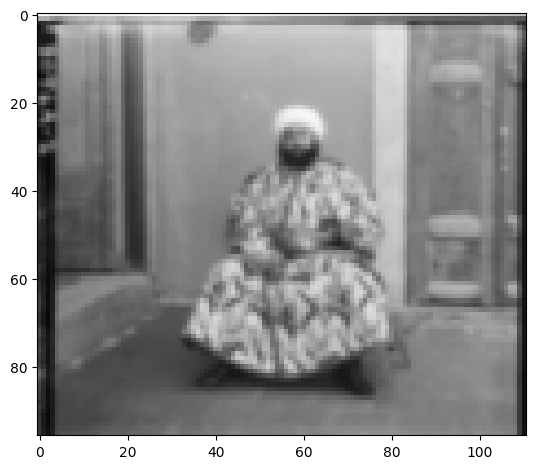

1 , 0
Best shift: (49, 23)
window (20, 20)


/var/folders/g4/d17nd2p53bs410zfk4zdgzr40000gn/T/ipykernel_1026/1303640730.py:10: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(img1)
/var/folders/g4/d17nd2p53bs410zfk4zdgzr40000gn/T/ipykernel_1026/1303640730.py:11: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


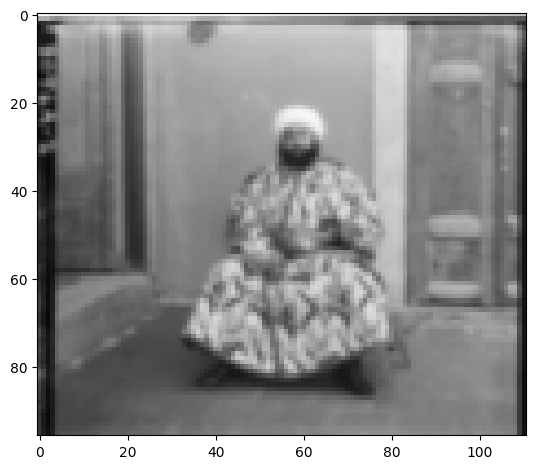

2 , 1
Best shift: (102, 40)


/var/folders/g4/d17nd2p53bs410zfk4zdgzr40000gn/T/ipykernel_1026/798862588.py:31: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(im_out)
/var/folders/g4/d17nd2p53bs410zfk4zdgzr40000gn/T/ipykernel_1026/798862588.py:32: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.show()


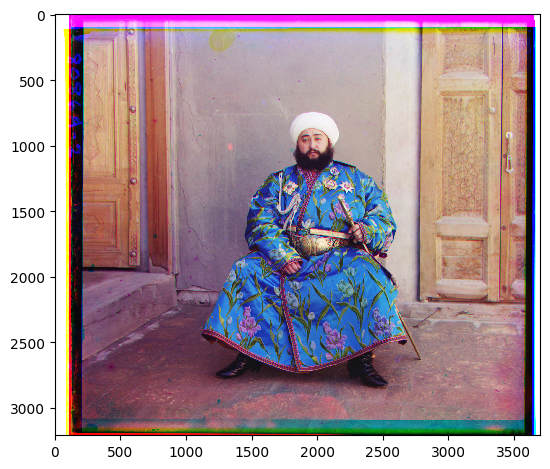

In [28]:
def align_img(img_path):
    # name of the input file
    imname = img_path

    # read in the image
    im = skio.imread(imname)

    # convert to double (might want to do this later on to save memory)    
    im = sk.img_as_float(im)
        
    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(int)

    # separate color channels
    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]

    ag, ag_shift = align((20, 20), b, g, 6, metric_func=ncc, overlap_views=True, default_window=(5,5), percent=0.024)
    ar, ar_shift = align((20, 20), b, r, 6, metric_func=ncc, overlap_views=True, default_window=(5,5), percent=0.024)
    im_out = np.dstack([ar, ag, b])

    filename, ext = os.path.splitext(os.path.basename(imname))
    fname = f'./output/{filename}_align_best.jpg'
    skio.imsave(fname, img_as_ubyte(im_out))

    with open("img_shift_data.txt", "a") as f:
        f.write(f"{filename} best shift (y,x) is ag: {ag_shift}, ar: {ar_shift} \n")

    # display the image
    skio.imshow(im_out)
    skio.show()

align_img('proj1_data/emir.tif')